In [ ]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='XXXXX-XXX-XXXX-XXX-XXX', project_access_token='p-XXXXXXXXXXXXXXXXXX')
pc = project.project_context



# Python Notebook interface for using WA-Testing-Tool

Date: 10.23.2019

## Introduction
This Notebook is a 'wrapper' that enables you to the run the <a href='https://github.com/cognitive-catalyst/WA-Testing-Tool'> WA-Testing Tool </a> on Watson Studio. You will need a Notebook with Python 3.6 XS or higher.


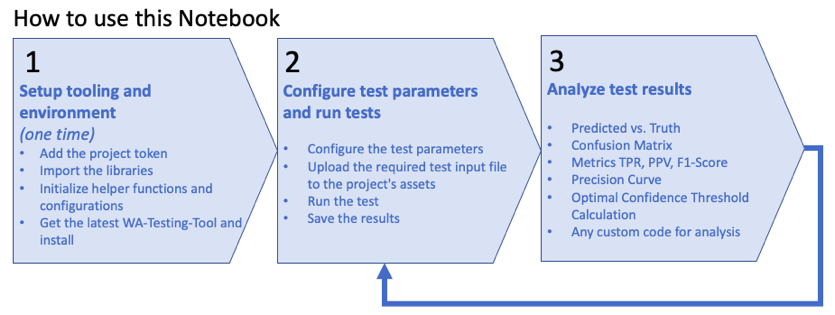

## Table of contents

<b>[1. Setup tooling and environment](#toolingenvsetup)</b> (These steps are needed only the first time)<br>
1.1. [Add the project token](#importproject)<br>
1.2. [Import the libraries](#importlibs)<br>
1.3. [Initialize helper functions and configurations](#initfuncs)<br>
1.4. [Get the latest WA-Testing-Tool and install](#gettooling)<br>

<b>[2. Configure test parameters and run tests](#prepruntest)</b> (These steps are for running the tests, one or more times, with different configurations)<br>
2.1. [Configure the test parameters](#configtestparams)<br>
2.2. [Upload the required test input file to the project's assets](#uploadfiles)<br>
2.3. [Run the test](#runtest)<br>
2.4. [(Optional) Save the results zip file to the project's asset](#saveresultstozip)<br>
2.5. [(Optional) Get other results files to the project assets](#getoutputfiles)<br>

<b>[3. Analyze test results](#analyzeresults)</b><br>
3.1. [Cross Validation KFold](#analysis-kfold)<br>
3.2. [Blind Test with Golden/Ground Truth](#analysis-blind)<br>
3.3. [Standard Test](#analysis-standardtest)<br>

<a id="toolingenvsetup"></a>
## 1. Setup tooling and environment

Login to the Watson Studio project you want to use for this Notebook. If you don’t have a Watson Studio project first create a new project in your account. You can use this link: https://dataplatform.cloud.ibm.com/projects/create-project

<a id="importproject"></a>
## 1.1. Add the project token

This Notebook uses Watson Studio project token. In a newly created project or if your existing Watson Studio project does not already have project token setup, make sure to set that up first.

Here are the steps:

Go to the “Settings” tab of your project and scroll to “Access tokens” and create an access token by clicking on “New token”. Provide a name eg – “For-WA-Tooling” give “Editor” access permissions.

(Complete instructions https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html)

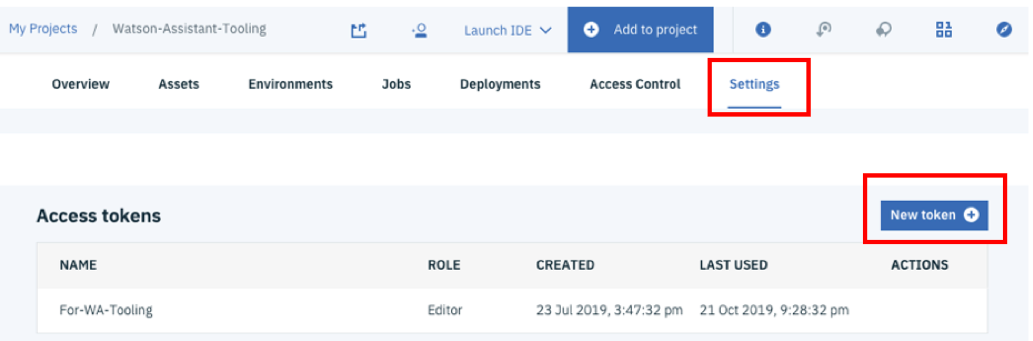



Add the project token to this Notebook:

1. Click on the three vertical dots in the top menu bar and then  "Insert project Token". (Read below if you don't have a project token setup yet.)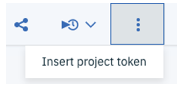
2. A new project token for your project should appear in the first cell.
2. Delete the example project token cell by selecting/highlighting it, then  Edit > Delete Cells
4. The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
5. Make sure to "Run' the cell with your token to initialize the project token into variables.

Example of the first cell (project token cell)
 ```@hidden_cell
 from project_lib import Project
 project = Project(project_id='d65cd0bf-xxxx-xxx-xxx-xxxx-xxx-xxxxx-', project_access_token='p-723xxxxxxxxxxyriuhdd8dd3oxxxxxxxxxxd')
 pc = project.project_context```


<br><br>
The next few cells import the libraries, setup the functions and environment configurations to help with the tooling installation. 
Typically, you don't need to change the default configurations. 
Just run the cells to initialize the code. (The testing related configurations will be in later steps)

<a id="importlibs"></a>
## 1.2. Import the libraries


In [ ]:
#Import the libraries
import configparser
import os
import sys

import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import json

<a id="initfuncs"></a>
## 1.3. Initialize helper functions and configurations

In [ ]:
# Initialize advanced configuration variables
# You do not need to change anything in these unless for advanced usage custom configuration
# just run the cell to initilize them
WS_USER_WORK_DIR_W_PATH= os.getcwd() #'/home/dsxuser/work' #Default Watson Studio user work directory
WA_TOOL_NOTEBOOK_DIR_W_PATH=WS_USER_WORK_DIR_W_PATH+'/'+'wa-tooling-notebook' 
WA_TOOL_INSTALL_DIR_W_PATH=WA_TOOL_NOTEBOOK_DIR_W_PATH+'/'+'WA-Testing-Tool' #directory where git clone extracts the tooling, default name; 
WA_TOOL_DATA_DIR_W_PATH=WA_TOOL_INSTALL_DIR_W_PATH+'/'+'data'
WA_TOOL_RESULTS_TARGZ_FILE='results_data.tar.gz'
WA_TOOL_GITHUB_URL='https://github.com/cognitive-catalyst/WA-Testing-Tool.git'
WA_TOOL_CONFIG_FILE_W_PATH = WA_TOOL_INSTALL_DIR_W_PATH +'/'+'config.ini'


In [ ]:
#To get current home directory 
print('\nCurrent home directory:')
print(os.getcwd())

#To get current working directory and install directory contents
print('\nCurrent working directory contents:')
!ls -ltr $WS_USER_WORK_DIR_W_PATH

#print('\nCurrent installation directory contents:')
#!ls -ltr $WA_TOOL_NOTEBOOK_DIR_W_PATH

#print('\nCurrent data directory contents:')
#!ls -ltr $WA_TOOL_DATA_DIR_W_PATH

#To delete all tooling installation
#!rm  -Rf $WA_TOOL_INSTALL_DIR_W_PATH

#To delete all tooling test data
#!rm  -Rf $WA_TOOL_DATA_DIR_W_PATH



In [ ]:
# You do not need to change anything in these function definitions, 
# just run the cells to initilize them

def copy_project_asset_file_to_python_env(project=project, asset_filename='asset_file_in_project', python_env_target_dir='python environemnt target directory'):
    filename_with_path=python_env_target_dir+'/'+asset_filename
    #print(os.listdir(python_env_target_dir))
    
    print('Copying file {0} from project assets to python environment'.format(asset_filename))
    file_from_project=project.get_file(asset_filename)
    file_to_write_local = open(filename_with_path, 'wb')
    file_to_write_local.write(file_from_project.read())
    file_to_write_local.close()
    file_from_project.close()

    print('Done.')
    print('Target directory listing: ')
    print(os.listdir(python_env_target_dir))
    print('File: ')
    print(os.stat(filename_with_path))


In [ ]:
def copy_python_env_file_to_project_asset(project=project, python_env_source_dir='python environemnt source directory', python_env_filename='python environment file name'):
    filename_with_path=python_env_source_dir+'/'+python_env_filename
    print('Source directory listing: ')
    print(os.listdir(python_env_source_dir))
    print('File: ')
    print(os.stat(filename_with_path))
    print('Copying file {0} from python environment to project assets'.format(python_env_filename))
    file_data=open(filename_with_path, 'rb')
    project.save_data(data=file_data.read(),file_name=python_env_filename,overwrite=True)
    file_data.close() 
    print('Done.')
    #print('Directory listing: ' + os.listdir(python_env_source_dir)

In [ ]:
def copy_python_env_data_results_zip_to_project_asset(project=project, data_results_zip_filename='zip file name'):
    
    #create a zip file of the data directory
    print('Verify data directoy was created/exists')
    print('Data directory listing: ')
    print(os.listdir(WA_TOOL_DATA_DIR_W_PATH))
  
    # !echo $WA_TOOL_INSTALL_DIR_W_PATH/$WA_TOOL_RESULTS_TARGZ_FILE $WA_TOOL_DATA_DIR_W_PATH

    print('Creating data zip file...')
    #subprocess.call(["tar", "-cvf", WA_TOOL_RESULTS_TARGZ_FILE, WA_TOOL_DATA_DIR_W_PATH])
    !tar -czvf $WA_TOOL_INSTALL_DIR_W_PATH/$WA_TOOL_RESULTS_TARGZ_FILE $WA_TOOL_DATA_DIR_W_PATH

    print('Verify .tar.gz file was created...')
    #check for the file in the list
    print('Directory listing. Check for the zip file: ')
    print(os.listdir(WA_TOOL_INSTALL_DIR_W_PATH))
    print('Zip file: ')
    print(os.stat(WA_TOOL_INSTALL_DIR_W_PATH+'/'+WA_TOOL_RESULTS_TARGZ_FILE))

    #copy thezip file to project asset
    print('Copying data zip file to project asset.')
    copy_python_env_file_to_project_asset(project, WA_TOOL_INSTALL_DIR_W_PATH, WA_TOOL_RESULTS_TARGZ_FILE)

In [ ]:
def copy_test_input_files_from_assets_to_python_env():
    
    #Depending on the test type copy  input files from the project asset to the local python env
    
    #If kfold no files needed
    #If blind or test we need test_input_file
    
    if ( PARAMS['mode'].lower() == 'kfold'):
        #do nothing
        print("No input files needed to copy for kfold.")
    if ( PARAMS['mode'].lower() == 'blind'):   
        # copy PARAMS['test_input_file'] to python env        
        print("Copying input file for blind test to python env...")
        copy_project_asset_file_to_python_env(project, PARAMS['test_input_file'], WA_TOOL_DATA_DIR_W_PATH)       
    if ( PARAMS['mode'].lower() == 'test'):   
        # copy PARAMS['test_input_file'] to python env
        print("Copying input file for standard test to python env...")
        copy_project_asset_file_to_python_env(project, PARAMS['test_input_file'], WA_TOOL_DATA_DIR_W_PATH)       

    ##Not using the feature of previous tests. 
    #Add this to PARAMS For later enhancement
    #'previous_blind_out' : 'NA', #; Previous blind test output file or NA. 'prev-test-out.csv | 'NA'
    #if ( PARAMS['previous_blind_out'].lower() != 'na'):   
        #PARAMS['previous_blind_out']
        #print("Copying previous_blind_out input file to python env...")
        #copy_project_asset_file_to_python_env(project, PARAMS['previous_blind_out'], WA_TOOL_DATA_DIR_W_PATH)       

    if ( PARAMS['partial_credit_table'].lower() != 'na'):   
        #PARAMS['partial_credit_table']
        print("Copying partial_credit_table input file to python env...")
        copy_project_asset_file_to_python_env(project, PARAMS['partial_credit_table'], WA_TOOL_DATA_DIR_W_PATH)
        
        
        

In [ ]:
def write_config_file_to_python_env():
    # Reads the basic user configution
    # Add the advanced configurations
    # Writes / or refreshes the configuration file to the file system where WA tool can read from
    #Some are common/fixed, some utilized from user input, and some are set based on conditions 
    
    config = configparser.ConfigParser()

    config['DEFAULT'] = {
        'mode': PARAMS['mode'],
        'workspace_id': PARAMS['workspace_id'],
        'output_directory': WA_TOOL_DATA_DIR_W_PATH, # './data', #PARAMS['temporary_file_directory'],
        'fold_num' : PARAMS['fold_num'],
        'keep_workspace_after_test' : 'no', #PARAMS['keep_workspace_after_test'],
        'weight_mode' : PARAMS['weight_mode'],
        'max_test_rate' : PARAMS['max_test_rate'],
        'conf_thres' : PARAMS['conf_thres']
    }

        
    config['ASSISTANT CREDENTIALS'] = {
        'username': PARAMS['username'],
        'password': PARAMS['password'],
        'iam_apikey': PARAMS['password'], #PARAMS['iam_apikey'],
        'url' : PARAMS['url'],
        'version' : PARAMS['version']
    }

    if ( PARAMS['mode'].lower() == 'kfold'):
        #config['DEFAULT']['test_output_path']= WA_TOOL_DATA_DIR_W_PATH+'/test-out-kfold.csv' #This is not needed for kfold. 
        config['DEFAULT']['out_figure_path']= WA_TOOL_DATA_DIR_W_PATH+'/kfold-figure.png'
        #config['DEFAULT']['kfold_figure_title']="Kfold Test" #There is no exposed variable for this. only for blind test
    
    if ( PARAMS['mode'].lower() == 'test'):
        config['DEFAULT']['test_input_file']= WA_TOOL_DATA_DIR_W_PATH+'/'+PARAMS['test_input_file'] #  './data/'+PARAMS['test_input_file'],
        config['DEFAULT']['test_output_path']= WA_TOOL_DATA_DIR_W_PATH+'/'+'test-out.csv' # PARAMS['test_output_file'] 
        

    if ( PARAMS['mode'].lower() == 'blind'):
        config['DEFAULT']['test_input_file']= WA_TOOL_DATA_DIR_W_PATH+'/'+PARAMS['test_input_file'] #  './data/'+PARAMS['test_input_file'],
        config['DEFAULT']['test_output_path']= WA_TOOL_DATA_DIR_W_PATH+'/'+'blind-test-out.csv' #PARAMS['test_output_file'] #
        config['DEFAULT']['out_figure_path']= WA_TOOL_DATA_DIR_W_PATH+'/blind-figure.png'
        config['DEFAULT']['blind_figure_title']="Blind Test with Golden Intent"

    ##TBD TBD  Not using the feature.
    #Add this to PARAMS
    #'previous_blind_out' : 'NA', #; Previous blind test output file or NA. 'prev-test-out.csv | 'NA'    
    #if previous blind output is provided add the line to the config file; otherwise don't add
    #if ( PARAMS['previous_blind_out'].lower() != 'na'):   
    #    config['DEFAULT']['previous_blind_out']= WA_TOOL_DATA_DIR_W_PATH+'/'+PARAMS['previous_blind_out'] # './data/'+PARAMS['previous_blind_out'],

    #if partial_credit_table is used add the line to the config file; otherwise don't add
    if ( PARAMS['partial_credit_table'].lower() != 'na'):   
        config['DEFAULT']['partial_credit_table']= WA_TOOL_DATA_DIR_W_PATH+'/'+PARAMS['partial_credit_table'] #'./data/'+PARAMS['partial_credit_table'],
    
    print('Writing config file...')
    with open(WA_TOOL_CONFIG_FILE_W_PATH, 'w') as configfile:
        config.write(configfile)
    configfile.close() 
    print('Done.')
    

<a id="gettooling"></a>
## 1.4. Get the latest WA-Testing-Tool and install

In [ ]:
# Make working dir for WA tooling as a sub dir of this WS work directory 
# Ignore if this already exists. It was created the first time
if not (os.path.exists(WA_TOOL_NOTEBOOK_DIR_W_PATH)): os.mkdir(WA_TOOL_NOTEBOOK_DIR_W_PATH)

In [ ]:
# Git clone the WA-Tooling to an install directory
# Ignore if this already exists. It was cloned if this is not the first time
!git clone $WA_TOOL_GITHUB_URL $WA_TOOL_INSTALL_DIR_W_PATH

In [ ]:
#Install the python libraries needed for the tooling
!pip install -r $WA_TOOL_INSTALL_DIR_W_PATH/requirements.txt # --upgrade 

<a id="prepruntest"></a>
## 2. Configure test parameters and run tests

<a id="configtestparams"></a>
## 2.1. Configure test parameters

Configure below the parameters for the WA-Testing tool

Note:

Three types of tests:
<br>
1. kfold test: ('KFOLD')
    - A test where the exiting training data is split into training and test sets. 
    - The model is trained with trainig set and the test data set is used to check performance
    - No input file is needed
    - Mostly used during initial model development to check performance of training data
<br>
2. blind test with golden/ground truth : ('BLIND')
    - A test where user supplies a csv file of utterances and the golden intent/ground truth
    - An input csv test file in this 2-column format is needed: utterance,goldent intent
    - The utterances are tested on the existing model to get the predicted intent
    - The utterance, goldent intent, predicted intent are available for performance analysis, eg how many were correct etc.
    - Mostly used for regression testing as the model changes
<br>
3. standard test without golden/ground truth : ('TEST')
    - A test where user supplies a csv file of utterances only 
    - An input csv test file in this format of a single column needed: utterance
    - The utterances are tested on the existing model to get the predicted intent
    - The utterance, predicted intent are available for review
<br>

Refer: https://github.com/cognitive-catalyst/WA-Testing-Tool

<a id="configtestparams-re"></a>

In [ ]:
#Configuration parameters in the JSON object below.
PARAMS = {
 
    #REQUIRED USER INPUT: Test type and information
    'mode': 'kfold', # ; KFOLD | BLIND | TEST ; If using BLIND or TEST upload test_input_file to the project Assets

    #REQUIRED USER INPUT:: Watson Assistant credentials
    'workspace_id': 'XXXXXXXXXXXXX', # <workspace_id or workspace JSON>
    'username': 'apikey', #; Enter username or if using apikey enter 'apikey'
    'password': 'XXXXXXXXXXXXXXXXX', #; Enter password or the value of apikey
    
    # Select the url for the WA API to match your specific WA region
    'url' : 'https://api.us-south.assistant.watson.cloud.ibm.com', # Dallas
    #'url' : 'https://api.us-east.assistant.watson.cloud.ibm.com', # Washington, DC
    #'url' : 'https://api.eu-de.assistant.watson.cloud.ibm.com', # Frankfort
    #'url' : 'https://api.au-syd.assistant.watson.cloud.ibm.com', # Sydney
    #'url' : 'https://api.jp-tok.assistant.watson.cloud.ibm.com', # Tokyo
    #'url' : 'https://api.eu-gb.assistant.watson.cloud.ibm.com', # London
    #'url' : 'https://api.kr-seo.assistant.watson.cloud.ibm.com', # Seoul
    
    'version' : '2019-02-28', #; Update the version of API to match your application or test needs

    #OPTIONAL USER INPUT:: input files names depending on the type of test. MUST match with files in project's Assets
    'test_input_file' : 'test_input.csv', # Test input file for and standard TEST (utterance) and BLIND (utterance,golden intent)
    
    #OPTIONAL USER INPUT:: advanced configuration options
    'partial_credit_table' : 'NA' ,  # Partial cretid file or NA. 'partial-credit-table.csv' | 'NA'
    'fold_num' : 2, #; Number of folds to use in KFOLD testing
    'weight_mode' : 'population', #; POPULATION | EQUAL | WEIGHT_FILE
    'max_test_rate' : 30, #; Test request rate, max 100. 
    'conf_thres' : 0.2 #; Threshold of confidence
    
} 

<a id="uploadfiles"></a>
## 2.2. Upload the required test input file to the project's assets
If any specifc input file is used, typically these are the ones specificed in: 
   - 'test_input_file' : 'test.csv', #; Test input file for BLIND and standard TEST
   - 'partial_credit_table' : 'partial-credit-table.csv' (optional, if us partial credits)

To do this, you can drag-drop the file on the right side to 'Find and Add data'. Or you can open another browser window, go to your Watson Studio Project page and add the file to the project Assets. Screenshots for both options shown below.

Make sure the filenames match on the assets and the configuration

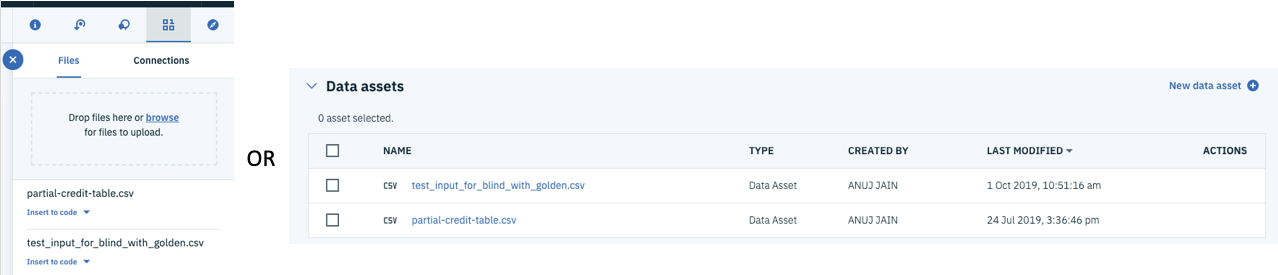

In [ ]:
# Generate/Update config file from the test configurations parameters
write_config_file_to_python_env()

In [ ]:
#View/confirm configuraiton file
!cat $WA_TOOL_INSTALL_DIR_W_PATH/config.ini

In [ ]:
# Copy the relevant input files from the Asset to local python env
copy_test_input_files_from_assets_to_python_env()

<a id="runtest"></a>
## 2.3. Run the test

In [ ]:
# Launch the test
!{sys.executable} $WA_TOOL_INSTALL_DIR_W_PATH/run.py -c $WA_TOOL_CONFIG_FILE_W_PATH

If the test completed successfully you will see '_Cleaned up workspaces_' as the last message. 
After that you can :

1. Save the output file to your project Assets (optional)
<br>and/or<br>
2. Proceed to analyzing the test output 
<br>
<br>

Quick links to analysis of results:
<br>
Link [3.3.1 - Cross Validation KFold Analysis](#analysis-kfold)<br>
Link [3.3.2 - Standard Test Analysis](#analysis-standardtest)<br>
Link [3.3.3 - Blind Test with Golden/Ground Truth Analysis](#analysis-blind)<br>


<a id="saveresultstozip"></a>
## 2.4 (Optional) Save the results zip file to the project's asset

In [ ]:
#Using this file name for the zip file
print(WA_TOOL_RESULTS_TARGZ_FILE)

In [ ]:
#To change the file name edit the variable below
WA_TOOL_RESULTS_TARGZ_FILE='results_data.tar.gz' 
print(WA_TOOL_RESULTS_TARGZ_FILE)

In [ ]:
copy_python_env_data_results_zip_to_project_asset(project, WA_TOOL_RESULTS_TARGZ_FILE)

In [ ]:
# Check the project Assets for the output zip file 
# Go to the project Assets tab and verify that the zip file was created. 
# Download it for further analysis.

<a id="getoutputfiles"></a>
## 2.5. (Optional) Get other results files to the project Assets

In [ ]:
# If you need specifc data output files to be placed to the a Project Asset, uncomment and use the copy_python_env_file_to_project_asset function.
# An example is shown below. Data directory variable is WA_TOOL_DATA_DIR_W_PATH (..../WA-Testing-Tool/data)
# Any sub-directory under the data directory will need to specified

In [ ]:
# To view current data output directory uncomment below
#os.listdir(WA_TOOL_DATA_DIR_W_PATH) # (./wa-tooling-notebook/WA-Testing-Tool/data/")

In [ ]:
# Examples, to get the output files to Assets
# To get the results csv files (eg kfold-out.csv, test-out.csv etc) 
# to project Assets edit the file name and uncomment below
#copy_python_env_file_to_project_asset(project, WA_TOOL_DATA_DIR_W_PATH, '<output-file-name>')

In [ ]:
# To view or confirm configuraiton file for local file locations uncomment below
#!cat $WA_TOOL_INSTALL_DIR_W_PATH/config.ini

<a id="analyzeresults"></a>
## 3. Analyze the results

<a id="analyzeresults"></a>
Link [3.1 - Cross Validation KFold Analysis](#analysis-kfold)<br>
Link [3.2 - Blind Test with Golden/Ground Truth Analysis](#analysis-blind)<br>
Link [3.3 - Standard Test Analysis](#analysis-standardtest)<br>

<a id="analysis-kfold"></a>
## 3.1. Cross Validation K-Fold Analysis
Use this if you ran 'KFOLD' test

### Predicted vs. Truth Match Output

In [ ]:
if ( PARAMS['mode'].lower() == 'kfold'):
    #Read test output file into a df

    #For golden/predicted for kfold test
    #os.listdir(WA_TOOL_DATA_DIR_W_PATH+'/kfold/kfold-out.csv') # (./wa-tooling-notebook/WA-Testing-Tool/data/kfold/kfold-out.csv")
    df_test_output_kfold = pd.read_csv(WA_TOOL_DATA_DIR_W_PATH+'/kfold-out.csv')
    df_test_output_kfold.head(10)

    # Copy this file to project Assets
    #copy_python_env_file_to_project_asset(project, WA_TOOL_DATA_DIR_W_PATH,'kfold-out.csv')

### Confusion Matrix

In [ ]:
if ( PARAMS['mode'].lower() == 'kfold'):
    #For confusion matrix for kfold test
    df_test_output_kfold_conf_args = pd.read_csv(WA_TOOL_DATA_DIR_W_PATH+'/kfold-out.confusion_args.csv')
    df_test_output_kfold_conf_args.head(50)

    # Copy this file to project Assets
    #copy_python_env_file_to_project_asset(project, WA_TOOL_DATA_DIR_W_PATH,'kfold-out.confusion_args.csv')

In [ ]:
if ( PARAMS['mode'].lower() == 'kfold'):
    # Chart
    Image(filename=WA_TOOL_DATA_DIR_W_PATH+'/kfold-out.confusion_args.png')

    # Copy this file to project Assets
    #copy_python_env_file_to_project_asset(project, WA_TOOL_DATA_DIR_W_PATH,'kfold-out.confusion_args.png')

### Metrics for TPR, PPV and F1-Score

In [ ]:
if ( PARAMS['mode'].lower() == 'kfold'):
    #For metrics for kfold test
    df_test_output_kfold_metrics = pd.read_csv(WA_TOOL_DATA_DIR_W_PATH+'/kfold-out.metrics.csv')
    df_test_output_kfold_metrics.head(50)

    # Copy this file to project Assets
    #copy_python_env_file_to_project_asset(project, WA_TOOL_DATA_DIR_W_PATH,'kfold-out.metrics.csv')

### Precision Curve

In [ ]:
if ( PARAMS['mode'].lower() == 'kfold'):
    # Chart
    Image(filename=WA_TOOL_DATA_DIR_W_PATH+'/kfold-figure.png')

    # Copy this file to project Assets
    #copy_python_env_file_to_project_asset(project, WA_TOOL_DATA_DIR_W_PATH,'kfold-figure.png')

Link [2.1 - Re-configure the test parameters](#configtestparams-re)<br>

<a id="analysis-blind"></a>
## 3.2. Blind Test Analysis
Use this if you ran 'BLIND' test

### Predicted vs. Truth (Golden) Match Output

In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    #For blind test
    #Predicted vs golden match
    #os.listdir(WA_TOOL_DATA_DIR_W_PATH+'/test-out.csv') # (./wa-tooling-notebook/WA-Testing-Tool/data/blind-test-out.csv")
    df_test_output_blind = pd.read_csv(WA_TOOL_DATA_DIR_W_PATH+'/'+'blind-test-out.csv')
    df_test_output_blind.head(50)

    # Copy this file to project Assets
    #copy_python_env_file_to_project_asset(project, WA_TOOL_DATA_DIR_W_PATH,'blind-test-out.csv')

### Confusion Matrix

In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    #For confusion matrix for blind test
    df_test_output_blind_conf_args = pd.read_csv(WA_TOOL_DATA_DIR_W_PATH+'/blind-test-out_confusion.csv')
    df_test_output_blind_conf_args.head(50)

    # Copy this file to project Assets
    #copy_python_env_file_to_project_asset(project, WA_TOOL_DATA_DIR_W_PATH,'blind-test-out_confusion.csv')

In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    Image(filename=WA_TOOL_DATA_DIR_W_PATH+'/blind-test-out_confusion.png')

    # Copy this file to project Assets
    #copy_python_env_file_to_project_asset(project, WA_TOOL_DATA_DIR_W_PATH,'blind-test-out_confusion.png')

### Metrics for TPR, PPV and F1-Score

In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    #Metrics
    #os.listdir(WA_TOOL_DATA_DIR_W_PATH+'/test-out.csv') # (./wa-tooling-notebook/WA-Testing-Tool/data/blind-test-out_metrics.csv")
    df_test_output_blind_metrics = pd.read_csv(WA_TOOL_DATA_DIR_W_PATH+'/'+'blind-test-out_metrics.csv')
    df_test_output_blind_metrics.head(50)

    # Copy this file to project Assets
    #copy_python_env_file_to_project_asset(project, WA_TOOL_DATA_DIR_W_PATH,'blind-test-out_metrics.csv')

### Precision Curve

In [ ]:
# Image

In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    Image(filename=WA_TOOL_DATA_DIR_W_PATH+'/blind-figure.png')

    # Copy this file to project Assets
    #copy_python_env_file_to_project_asset(project, WA_TOOL_DATA_DIR_W_PATH,'blind-figure.png')

### Optimal Confidence Threshold Calculation (Tau value)

In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    # TAU Threshold Calculation
    # Visual
    import matplotlib.pyplot as plt
    from operator import itemgetter
    import numpy as np

    df1=df_test_output_blind

In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    #Distribution of match yes and no across thresholds shown together (scale of y axis is same for both)

    x = df1[df_test_output_blind['does intent match']=='yes']['confidence']
    y = df1[df_test_output_blind['does intent match']=='no']['confidence']
    bins = np.linspace(0, 1, 10)

    plt.hist([x, y], bins, label=['correct', 'incorrect']) #label=['x', 'y']
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    #Distribution of match yes or no across thresholds shown individually 
    # NOTE scale of y axis may be different
    df1.hist(column="confidence",by="does intent match",bins=10, figsize=(10,4))

In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    #Total distribution across thresholds
    w=pd.Series(df1['confidence']).plot(kind='hist', bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]) # `bins` defines the start and end points of bins


In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    #Distribution of match yes or no across thresholds shown as box plot to see the extent of values 
    %matplotlib inline
    df1.boxplot(column="confidence",by="does intent match")

In [ ]:
# TAU Threshold Calculation

# SIMPLE FORMULA - maximize corrects and minimize incorrects for a thresholds
# do not consider ignored (below threshold)



In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    thresholds_results =[]

    print('total:' + str(len (df1)))

    for i in range(0,100,1):
        test_tau=i/100
        #print(test_tau)

        correct_weight = 1
        incorrect_weight = -1.5
        ignored_weight = 0 #ignore impact of below threshold

        #get number of correct, incorrect and irrelevant counts
        #df_tau_test=df1[(df1['match']=='yes') & (df1['confidence']>=test_tau)]
        total_count = len (df1)
        correct_count = len (df1[(df1['does intent match']=='yes') & (df1['confidence']>=test_tau)])
        incorrect_count = len (df1[(df1['does intent match']=='no') & (df1['confidence']>=test_tau)])
        ignored_count = len (df1[(df1['confidence']<test_tau)]) 

        #apply scores
        score = ((correct_weight*correct_count) + (incorrect_weight*incorrect_count) + (ignored_weight*ignored_count))
        print('test_tau:' + str(test_tau) + ' correct:' + str(correct_count) + ' incorrect:' + str(incorrect_count) + ' ignored:' + str(ignored_count) + ' score:' + str(score))
        thresholds_results.append((test_tau,score))


In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    optimum_condfidence_threshold, max_score = max(thresholds_results, key=itemgetter(1))
    print('optimum_condfidence_threshold', optimum_condfidence_threshold)
    print('max_score', max_score)


In [ ]:
# TAU Threshold Calculation

# COMPLEX FORMULA - maximize corrects and minimize incorrects for a thresholds, and also minimize the ignored (below threshold)

Interpretation:
Threshold with highest score provides the best mix of "true positive" (corrects) and "false positives" (incorrects), pass/skipped i.e. "true negatives" (below threshold but correct) and "false negatives" (below threshold but incorrect).
This distribution is based on the weights. 
If pass/skipped weight is set 0, check how many of total are passed. Ideally passed should not be more than the true positives at the selected tau level and of course should be less incorrects

In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    thresholds_results =[]

    print('total:' + str(len (df1)))

    for i in range(0,100,1):
        test_tau=i/100
        #print(test_tau)

        correct_weight = 1
        incorrect_weight = -1.5
        ignored_correct_weight = -1
        ignored_incorrect_weight = 1


        #ignored_weight = 0 #0 #since we are using nudging this can be ignored. More useful for chat use cases.

        #get number of correct, incorrect and irrelevant counts
        #df_tau_test=df1[(df1['match']=='yes') & (df1['confidence']>=test_tau)]
        total_count = len (df1)
        correct_count = len (df1[(df1['does intent match']=='yes') & (df1['confidence']>=test_tau)])
        incorrect_count = len (df1[(df1['does intent match']=='no') & (df1['confidence']>=test_tau)])
        ignored_correct_count = len (df1[(df1['does intent match']=='yes') & (df1['confidence']<test_tau)])
        ignored_incorrect_count = len (df1[(df1['does intent match']=='no') & (df1['confidence']<test_tau)])
        ignored_count = ignored_correct_count + ignored_incorrect_count

        #apply scores
        #score = ((correct_weight*correct_count) + (incorrect_weight*incorrect_count) + (ignored_weight*ignored_count))
        score = ((correct_weight*correct_count) + (incorrect_weight*incorrect_count) + (ignored_correct_weight*ignored_correct_count) + (ignored_incorrect_weight*ignored_incorrect_count))

        print('test_tau:' + str(test_tau) + ' correct:' + str(correct_count) + ' incorrect:' + str(incorrect_count) + ' ignored_correct:' + str(ignored_correct_count) +  ' ignored_incorrect:' + str(ignored_incorrect_count) + ' score:' + str(score))
        thresholds_results.append((test_tau,score))


        #Interpretation:
        # threshold with highest score provides the best mix of "true positive" (corrects) and "false positives" (incorrects)
        # and pass/skipped ie. "true negatives" (below threshold but correct) and "false negatives" (below threshold but incorrect) based on the weights
        # if pass weight is 0 , check how many of total are passed. 
        # ideally passed should not be more than the true positives at the selected tau level
        # and of course less incorrects


In [ ]:
if ( PARAMS['mode'].lower() == 'blind'):
    optimum_condfidence_threshold, max_score = max(thresholds_results, key=itemgetter(1))
    print('optimum_condfidence_threshold', optimum_condfidence_threshold)
    print('max_score', max_score)

Link [2.1 - Re-configure the test parameters](#configtestparams-re)<br>

<a id="analysis-standardtest"></a>
## 3.3. Standard Test Analysis
Use this if you ran standard 'TEST' test

In [ ]:
if ( PARAMS['mode'].lower() == 'test'):
    #For standard test
    #os.listdir(WA_TOOL_DATA_DIR_W_PATH+'/test-out.csv') # (./wa-tooling-notebook/WA-Testing-Tool/data/test-out.csv")
    df_test_output_standard = pd.read_csv(WA_TOOL_DATA_DIR_W_PATH+'/'+'test-out.csv')

    df_test_output_standard.head(50)

    # Copy this file to project Assets
    #copy_python_env_file_to_project_asset(project, WA_TOOL_DATA_DIR_W_PATH,'test-out.csv')

Link [2.1 - Re-configure the test parameters](#configtestparams-re)<br>

In [ ]:
################################
####### END OF SCRIPT
################################
